# Part 2: Limits of array-oriented programming

Now that we've seen the advantages of array-oriented programming, let's consider its disadvantages.

<br><br><br>

## Performance

Although computing a mathematical formula on millions of values is a lot faster with NumPy arrays than it is with Python scalars, it's not the fastest way to do it.

In [1]:
import numpy as np
import numexpr as ne

Quadratic formula (one solution $x$ of $ax^2 + bx + c = 0$), just to have something to calculate:

$$ x = \frac{-b + \sqrt{b^2 - 4ac}}{2a} $$

In [2]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

In [3]:
a = np.random.uniform(5, 10, 5_000_000)
b = np.random.uniform(10, 20, 5_000_000)
c = np.random.uniform(-0.1, 0.1, 5_000_000)

<br><br><br>

In [4]:
%%timeit -n1 -r3

imperative = np.empty_like(c)
for i, (ai, bi, ci) in enumerate(zip(a, b, c)):
    imperative[i] = quadratic_formula(ai, bi, ci)

7.4 s ± 9.39 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [5]:
%%timeit -n1 -r3

quadratic_formula(a, b, c)

44.2 ms ± 15.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
%%timeit -n1 -r3

ne.evaluate("(-b + sqrt(b**2 - 4*a*c)) / (2*a)")

7.21 ms ± 1.16 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<br><br><br>

Why is NumPy so much slower than NumExpr?

<br><br><br>

Each mathematical operation (`+`, `*`, `np.sqrt`) of the NumPy calculation performs that operation on the whole array before moving on to the next operation. If the arrays are larger than your CPU's L1, L2, and L3 caches, it will be forced to get the data from RAM, and memory transfers are usually slower than computing a whole mathematical formula.

What NumPy is doing is almost like this:

In [7]:
def pedantic_quadratic_formula(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8

<br><br><br>

Confirm with a performance test:

In [8]:
%%timeit -n1 -r3

pedantic_quadratic_formula(a, b, c)

56.5 ms ± 3.77 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [9]:
%%timeit -n1 -r3

quadratic_formula(a, b, c)

34.9 ms ± 3.14 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


_(Caveat: NumPy is able to "fuse" some operations, so it's sometimes a little better than the completely "unfused" `pedantic_quadratic_formula`, but both of the above times are much slower than NumExpr.)_

<br><br><br>

NumExpr, on the other hand, turns the `"(-b + sqrt(b**2 - 4*a*c)) / (2*a)"` expression into something that it can compute quickly (a virtual machine like Python, but a lower-overhead one that only does mathematical operations).

<br><br><br>

We could go even further by actually compiling the expression using Numba:

In [10]:
import numba as nb

@nb.vectorize
def numba_quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

numba_quadratic_formula(a, b, c)

array([-0.00542384, -0.00500319,  0.00456461, ...,  0.00367107,
        0.00036945, -0.00736863], shape=(5000000,))

In [11]:
%%timeit -n100 -r3

numba_quadratic_formula(a, b, c)

7.22 ms ± 10.2 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)


<br><br><br>

Or compile it with JAX (we'll hear more about JAX):

In [12]:
import jax
jax.config.update("jax_platform_name", "cpu"); jax.config.update("jax_enable_x64", True)

@jax.jit
def jax_quadratic_formula(a, b, c):
    return (-b + jax.numpy.sqrt(b**2 - 4*a*c)) / (2*a)

jax_quadratic_formula(a, b, c)

Array([-0.00542384, -0.00500319,  0.00456461, ...,  0.00367107,
        0.00036945, -0.00736863], dtype=float64)

In [13]:
%%timeit -n100 -r3

jax_quadratic_formula(a, b, c)

3.08 ms ± 495 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)


<br><br><br>

Let's make a scorecard:

In [14]:
import matplotlib.pyplot as plt

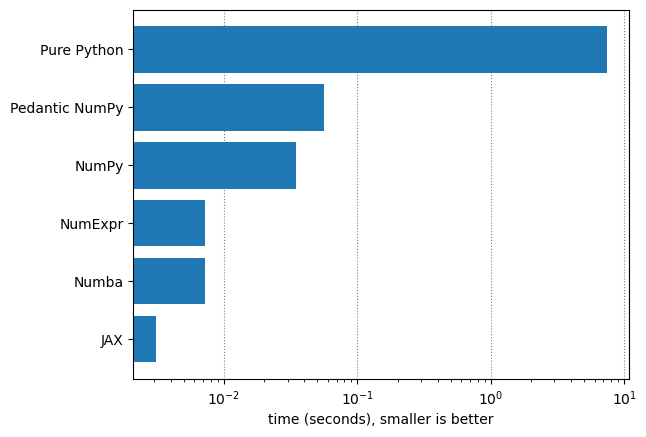

In [16]:
fig, ax = plt.subplots()

scorecard = [
    ("Pure Python",     7.4e0),
    ("Pedantic NumPy", 56.5e-3),
    ("NumPy",          34.9e-3),
    ("NumExpr",        7.21e-3),
    ("Numba",          7.22e-3),
    ("JAX",            3.08e-3),
]

ax.barh([x for x, y in scorecard[::-1]], [y for x, y in scorecard[::-1]])
ax.grid(axis="x", ls=":", c="gray")
ax.set_axisbelow(True)
ax.set_xscale("log")
ax.set_xlabel("time (seconds), smaller is better")

None

The exact results depend on many things, but there's a general pattern of NumPy being orders of magnitude faster than pure Python, while compiled, "single-pass" implementations are several times faster than NumPy.

<br><br><br>

## Expressiveness

There are some 